# library

In [2]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import FinanceDataReader as fdr

import datetime as dt

import numpy as np

from tqdm import tqdm #진행바
from tqdm.notebook import tqdm

#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))


#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


import warnings
warnings.filterwarnings('ignore')

# GPU
import tensorflow as tf

#https://www.tensorflow.org/guide/gpu#allowing_gpu_memory_growth
#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
#지정해서 쓰고 싶으면 model 쓸 때는 with 구문 안에 넣기

matplotlib version: 3.4.2
seaborn version: 0.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# data load 및 classification 전처리

In [3]:
df = pd.read_csv('minmax_stock_2018_10days.csv')
df['Next_Change'] = np.where(df['Next_Change']>0.05, 1, 0)

# 분류

## 머신러닝 K-fold 교차 검증(cross validation)
데이터를 5-fold 교차검증으로 8개 모델을 학습하고 예측하여 평가한다.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
import time

results=[]

def classification(model_):
    
    # data load
    df_ = pd.read_csv('minmax_stock_2018_10days.csv')
    df_['Next_Change'] = np.where(df_['Next_Change']>0.05, 1, 0)
    
    # data split X, y
    X = df_.iloc[:,2:-1]
    y = df_.iloc[:,-1]
    i=0

    # Cross Validation
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for train_idx, test_idx in tqdm(sss.split(X,y)):
        x_train = df_.iloc[train_idx,2:-1]
        y_train = df_.iloc[train_idx,-1]
        x_test = df_.iloc[test_idx,2:-1]
        y_test = df_.iloc[test_idx,-1]
        
        _ = model_.fit(x_train, y_train)
        
        y_pred_train = model_.predict(x_train) 
        y_pred_test = model_.predict(x_test) # 예측
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        roc_auc = roc_auc_score(y_test, y_pred_test)
        
        dummy = DummyClassifier(strategy = 'stratified', random_state = 1) # strategy 옵션: 'stratified', 'uniform', 'most_frequent'
        _ = dummy.fit(x_train, y_train)
        dummy_score = dummy.score(x_test, y_test)
        
        results.append([i,f'{str(model)[:str(model).index("(")]}',accuracy_train,accuracy_test, roc_auc, dummy_score])#, training_time
        i+=1
        
        

In [5]:
%%time

# 1. Logistic regression    
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
temp = classification(model)


# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
temp = classification(model)


# 3. Support vector machine
from sklearn.svm import SVC
model = SVC()
temp = classification(model)


# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
temp = classification(model)


# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
temp = classification(model)


# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = classification(model)


# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
temp = classification(model)


# 8. Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
temp = classification(model)


# results
# # 형태: i번째 학습, 학습 모델, train 정확도, test 정확도(최종정확도), roc_auc, dummy 학습에 걸린 시간

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 3min 24s, sys: 1min 50s, total: 5min 14s
Wall time: 2min 15s


## 교차검증 결과 종합

In [6]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_test', 'roc_auc', 'dummy'])#,'training_time'
df_results

,iter,method,accuracy_train,accuracy_test,roc_auc,dummy
0,0,LogisticRegression,0.918186,0.917323,0.500000,0.844488
1,1,LogisticRegression,0.918186,0.917323,0.500000,0.836614
2,2,LogisticRegression,0.918186,0.917323,0.500000,0.848425
3,3,LogisticRegression,0.918186,0.917323,0.500000,0.844488
4,4,LogisticRegression,0.918186,0.917323,0.500000,0.844488
5,0,DecisionTreeClassifier,1.000000,0.832677,0.551349,0.844488
6,1,DecisionTreeClassifier,1.000000,0.870079,0.593399,0.836614
7,2,DecisionTreeClassifier,1.000000,0.838583,0.511241,0.848425
8,3,DecisionTreeClassifier,1.000000,0.875984,0.596618,0.844488
9,4,DecisionTreeClassifier,1.000000,0.868110,0.538167,0.844488


## 테스트 데이터셋 정확도 플랏

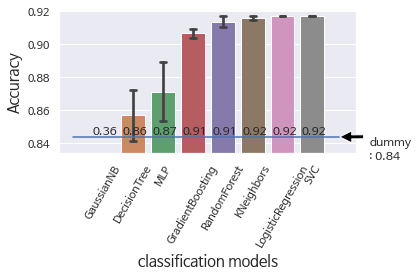

In [7]:
ax = sns.barplot(x="method", y="accuracy_test", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
_ = ax.set_xticks(range(8))

################################################################################
# xticklabels
dummy_mean = df_results.groupby('method').mean().sort_values('accuracy_test')['dummy'].mean()
_ = ax.set(ylim=(dummy_mean - 0.01, 0.921))


tick_list = []
for i in ax.get_xticklabels():
    text = str(i).split(',')[2].split("'")[1]
    if 'Classifier' in text:
        text = text[:text.index("C")]
    tick_list.append(text)
################################################################################

_ = ax.set_xticklabels(tick_list,rotation=60); # ax.get_xticklabels()

_ = ax.set_xlabel("classification models", fontsize = 15)
_ = ax.set_ylabel("Accuracy", fontsize = 15)

val = df_results.groupby('method').mean().sort_values('accuracy_test')['accuracy_test']
cnt = 0
for i in range(8):
    _ = ax.text(cnt-0.35, 0.845, f'{val[i]:.2f}')
    cnt += 1

_ = ax.plot([-1,8], [dummy_mean, dummy_mean])
_ = ax.annotate(f'dummy\n: {dummy_mean:.2f}', xy = (7.8, dummy_mean), xytext = (8.9, 0.83),
               arrowprops = dict(facecolor = 'black', shrink = 0.1),)

_ = plt.tight_layout()

## 훈련-테스트 데이터셋 정확도 플랏

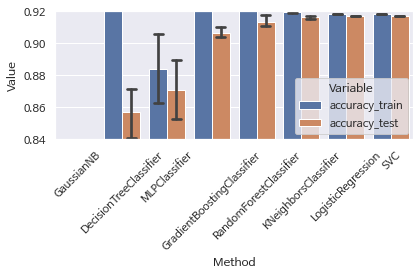

In [8]:
tidy = df_results[['method', 'accuracy_train', 'accuracy_test']].melt(id_vars='method').rename(columns=str.title)
ax = sns.barplot(x="Method", y="Value", hue='Variable', data=tidy, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_test').index)
_ = ax.set(ylim=(0.84, 0.92))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
_ = plt.tight_layout()

## roc-auc plot

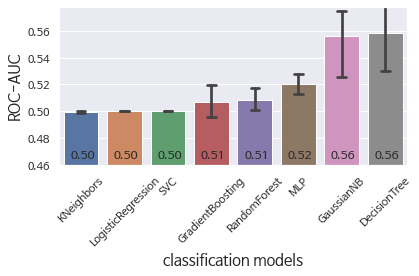

In [9]:
ax = sns.barplot(x="method", y="roc_auc", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('roc_auc').index)
_ = ax.set_xticks(range(8))
_ = ax.set(ylim=(0.46, 0.578))

# xticklabels
tick_list = []
for i in ax.get_xticklabels():
    text = str(i).split(',')[2].split("'")[1]
    if 'Classifier' in text:
        text = text[:text.index("C")]
    tick_list.append(text)
# tick_list

_ = ax.set_xticklabels(tick_list,rotation=45);## 테스트 데이터셋 정확도 플랏

_ = ax.set_xlabel("classification models", fontsize = 15)
_ = ax.set_ylabel("ROC-AUC", fontsize = 15)

val = df_results.groupby('method').mean().sort_values('roc_auc')['roc_auc']
cnt = 0
for i in range(8):
    _ = ax.text(cnt-0.25, 0.465, f'{val[i]:.2f}')
    cnt += 1

_ = plt.tight_layout()

# 회귀

In [14]:
results = []

def my_regressor():
    df_ = pd.read_csv('minmax_stock_2018_10days.csv')
    # data split X, y
    df_X = df_.iloc[:,2:-1]
    df_y = df_['Next_Change']#.iloc[:,-1]
    
    from sklearn.linear_model import LinearRegression # 일반 회귀 모델
    from sklearn.linear_model import Ridge, Lasso, ElasticNet # Norm 규제 회귀 모델
    from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
    from sklearn.ensemble import RandomForestRegressor # decision tree 앙상블 모델, 배깅
    from xgboost import XGBRegressor # decision tree 앙상블 모델, 부스팅
#     from sklearn.model_selection import cross_val_score # model 검증
    
#     from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import ShuffleSplit
    
    from sklearn.dummy import DummyRegressor
    from sklearn import metrics
    
    import ast # convert string to function
    import numpy as np
    
    ################################################### 전처리 파이프라인
#     from sklearn.pipeline import Pipeline
#     from sklearn.impute import SimpleImputer
#     from sklearn.preprocessing import MinMaxScaler

#     my_pipeline = Pipeline([('mean_imputer', SimpleImputer(strategy = 'mean')),
#                            ('mm_scaler', MinMaxScaler())])
    ##############################################################################

    
    linear = LinearRegression()
    ridge, lasso, elasticnet = Ridge(), Lasso(), ElasticNet()
    ardr_linear, baysian_ridge = ARDRegression(), BayesianRidge()
    random_forest = RandomForestRegressor()
    xgboost_linear = XGBRegressor()
    dummy = DummyRegressor(strategy = 'mean')
    
    my_model_list = ['linear', 'ridge', 'lasso', 'elasticnet',
                     'ardr_linear', 'baysian_ridge',
                     'random_forest', 'xgboost_linear', 'dummy']
    
    ######################################################################### fitting
    for model_nm in tqdm(my_model_list):
        
        # cv
        ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        for train_idx, test_idx in tqdm(ss.split(df_X,df_y)):
            i=1
            x_train = df_.iloc[train_idx,2:-1]
            y_train = df_.iloc[train_idx,-1]
            x_test = df_.iloc[test_idx,2:-1]
            y_test = df_.iloc[test_idx,-1]

            y_train = np.array(y_train).reshape(-1, 1)
            y_test = np.array(y_test).reshape(-1, 1)

#             # 전처리 (scaling)
#             x_train_fit = my_pipeline.fit(x_train)
#             x_train_pre = x_train_fit.transform(x_train)
#             x_test_pre = x_train_fit.transform(x_test)

#             y_train_fit = my_pipeline.fit(y_train)
#             y_train_pre = y_train_fit.transform(y_train)
#             y_test_pre = y_train_fit.transform(y_test)
            ########################################################
        
            # fitting
            model_ = eval(model_nm).fit(x_train, y_train)
            y_pred_test = model_.predict(x_test) # 예측

            mse_score = metrics.mean_squared_error(y_test, y_pred_test)

            results.append([i, f'{model_nm}', mse_score]) #[:str(model).index("(")]
            i+=1
            #####################################################################################
    
    return results#score_dic#[0]

In [15]:
%%time
_ = my_regressor()
results

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 20min 12s, sys: 5min 41s, total: 25min 53s
Wall time: 11min 3s


[[1, 'linear', 0.00409991747036772],
 [1, 'linear', 0.00650029618368558],
 [1, 'linear', 0.004146339125564833],
 [1, 'linear', 0.006658600971369647],
 [1, 'linear', 0.003724265106056277],
 [1, 'ridge', 0.003485821501930223],
 [1, 'ridge', 0.00363576249726788],
 [1, 'ridge', 0.003586655639271022],
 [1, 'ridge', 0.002989436689967999],
 [1, 'ridge', 0.003900825131926314],
 [1, 'lasso', 0.0033656972409363945],
 [1, 'lasso', 0.0034319491675740377],
 [1, 'lasso', 0.0033770333512148057],
 [1, 'lasso', 0.0027669478970818125],
 [1, 'lasso', 0.003326681285597424],
 [1, 'elasticnet', 0.0033823197213126923],
 [1, 'elasticnet', 0.0034446197650190736],
 [1, 'elasticnet', 0.0034185191304947848],
 [1, 'elasticnet', 0.0027891476972153055],
 [1, 'elasticnet', 0.0036380356537391656],
 [1, 'ardr_linear', 0.00332856609180192],
 [1, 'ardr_linear', 0.0033666567908068315],
 [1, 'ardr_linear', 0.0032203044955378887],
 [1, 'ardr_linear', 0.0027483359479693165],
 [1, 'ardr_linear', 0.0025918814813892443],
 [1, '

In [16]:
dic = {}
for i in results:
    if i[1] not in dic: # dic.keys()라고 써도 됨.
        dic[i[1]] = [i[2]]
    else:
        dic[i[1]].append(i[2])


# import math
# 리스트에 mean 함수가 내장이 안돼있다니...

for i in dic.keys():
    dic[i] = sum(dic[i])/len(dic[i])


score_lst = sorted(dic.items(), key = lambda t : t[1]) #mse 작은 순으로 줄 세워짐.
score_lst
# dic.keys()

[('ardr_linear', 0.00305114896150104),
 ('dummy', 0.00305114896150104),
 ('lasso', 0.0032536617884808953),
 ('random_forest', 0.003263416722087748),
 ('elasticnet', 0.003334528393556204),
 ('xgboost_linear', 0.0034724474788781377),
 ('baysian_ridge', 0.0034809543369311185),
 ('ridge', 0.0035197002920726883),
 ('linear', 0.005025883771408812)]

In [17]:
score_dic = {}
for i in score_lst:
    score_dic[i[0]] = i[1]

In [18]:
df = pd.DataFrame(score_dic.items(), columns=['key', 'value'])
df

,key,value
0,ardr_linear,0.003051
1,dummy,0.003051
2,lasso,0.003254
3,random_forest,0.003263
4,elasticnet,0.003335
5,xgboost_linear,0.003472
6,baysian_ridge,0.003481
7,ridge,0.003520
8,linear,0.005026


In [20]:
dummy_mean = df[df.key=='dummy']['value'].values
df[df.key=='dummy']['value'].values
f'dummy\n: {dummy_mean[0]:.2f}'

array([0.00305115])

'dummy\n: 0.00'

# MSE plot

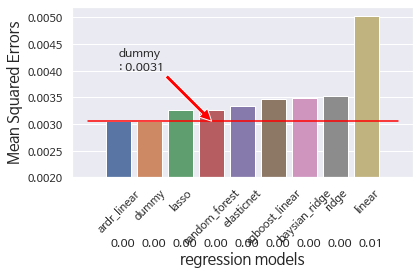

In [35]:
g = sns.barplot(x = 'key', y = 'value', data=df, capsize=.2)
_ = g.set_xticks(range(len(df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=45)
_ = g.set_xlabel("regression models", fontsize = 15)
_ = g.set_ylabel("Mean Squared Errors", fontsize = 15)
_ = g.set_ylim([0.002, 0.0052]) # ax.set(ylim=(0.4, 0.6))
dummy_mean = df[df.key=='dummy']['value'].values
_ = g.plot([-1,len(df)], [dummy_mean, dummy_mean], color = 'red')
_ = g.annotate(text = f'dummy\n: {dummy_mean[0]:.4f}', xy = (3, dummy_mean), xytext = (0.01, 0.004),
               arrowprops = dict(facecolor = 'red', shrink = 0),)


val = df['value']
cnt = 0
for i in range(len(df)):
    _ = g.text(cnt-0.27, 0.0007, f'{val[i]:.2f}')
    cnt += 1

plt.tight_layout()
# bar plot official doc
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# .set_xticklabels rot
# https://data-newbie.tistory.com/261
# .set_label
# https://www.delftstack.com/ko/howto/seaborn/seaborn-lineplot/